### contents
- For passive trials, vs active trials
- For each unit, for each stimuli, for each cue, for each timepoint
   - compute the average difference in spikerate within cue, versus between cue

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
os.nice(1) 

1

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

/mnt/cube/tsainbur/conda_envs/cdcp_paper_cube/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
from datetime import datetime

In [5]:
from cdcp.spiketrain_analysis.unit_statistics import get_unit_spike_trains

In [6]:
from cdcp.spiketrain_analysis.unit_stats.response_similarity_differences_rel_shuff import (
    compute_cued_sm_differences
)

In [7]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [9]:
min_playbacks = 1000

### Compute spike vectors and statistics

In [10]:
identifier = "temporal_cuing_25ms"

In [11]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
)


def create_cue_count_df(trial_aligned_spikes, cues=["CL1", "CL0", "NC", "CR0", "CR1"]):

    cues = [i for i in trial_aligned_spikes.cue.unique() if i in cues]

    stim_cue_count_df = trial_aligned_spikes[["cue", "interp", "interp_point_binned"]]
    stim_cue_count_df["stim"] = [
        i + "_" + str(j)
        for i, j in zip(stim_cue_count_df.interp, stim_cue_count_df.interp_point_binned)
    ]
    stim_cue_count_df = stim_cue_count_df[["stim", "cue"]]
    cue_count_df = (
        pd.DataFrame(stim_cue_count_df[["stim", "cue"]].value_counts())
        .reset_index()
        .pivot(index="stim", columns=["cue"], values=[0])
    )
    cue_count_df = cue_count_df.droplevel(0, axis=1)
    cue_count_df = cue_count_df[cues]
    cue_count_df["min_val"] = [
        np.nanmin(row.values) for idx, row in cue_count_df.iterrows()
    ]
    cue_count_df["good_interps"] = [
        np.sum(np.isnan(row.values) == False) for idx, row in cue_count_df.iterrows()
    ]
    cue_count_df = cue_count_df.sort_values(
        by=["good_interps", "min_val"], ascending=False
    )
    return cue_count_df


def compute_temporal_cuing(
    trial_aligned_spikes,
    flip_bins=True,
    n_time_bins=100,
    n_interp_point_bins=16,
    nex=20,
    mode="constant",
):
    passive_active = ["passive", "active"]
    if np.mean(trial_aligned_spikes.passive == False) == 1:
        return pd.Series()

    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].values.astype(int),
        n_interp_point_bins,
        flip_bins=True,
    )

    # get passive and active seperately
    passive_trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.passive]
    active_trial_aligned_spikes = trial_aligned_spikes[
        trial_aligned_spikes.passive == False
    ]
    # only get trials with a decision
    active_trial_aligned_spikes = active_trial_aligned_spikes[
        active_trial_aligned_spikes.response.isin(["left", "right"])
    ]
    # create a dataframe of counts for each stimuli & cue of how many occurances
    passive_cue_count_df = create_cue_count_df(passive_trial_aligned_spikes)
    active_cue_count_df = create_cue_count_df(active_trial_aligned_spikes)
    cue_count_df = passive_cue_count_df.merge(
        active_cue_count_df, on="stim", suffixes=["_passive", "_active"]
    )

    # sort by the minimum number of interpolation types for each cue, passive and active
    cue_count_df["all_good_interps"] = [
        np.min([row.good_interps_passive, row.good_interps_active])
        for idx, row in cue_count_df.iterrows()
    ]
    cue_count_df["min_count_all"] = [
        np.min([row.min_val_passive, row.min_val_active])
        for idx, row in cue_count_df.iterrows()
    ]
    cue_count_df = cue_count_df.sort_values(
        by=["all_good_interps", "min_count_all"], ascending=False
    )

    # for each stimuli (sorted by data amount, up to nex samples for this unitt)
    diff_all = []
    if nex == -1:
        nex = len(cue_count_df)
    for axi, (idx, row) in enumerate(
        tqdm(cue_count_df[:nex].iterrows(), total=nex, desc="stims", leave=False)
    ):
        interp, ip = row.name.split("_")
        if row.all_good_interps < 2:
            continue

        # for both passive and active trials
        for ti, trial_aligned_spikes in enumerate(
            [passive_trial_aligned_spikes, active_trial_aligned_spikes]
        ):
            # grab the relevant data
            trial_df = trial_aligned_spikes[
                (trial_aligned_spikes.interp == interp)
                & (trial_aligned_spikes.interp_point_binned == int(ip))
            ]
            trial_df = trial_df[trial_df.cue.isin(["CL0", "CR0", "CL1", "CR1"])]
            if len(trial_df) == 0:
                continue
            trial_df["cue_randomized"] = np.random.permutation(trial_df.cue.values)
            sts = np.stack(trial_df.spike_vectors.values).astype(float)
            # for each cue type
            for cue in trial_df.cue.unique():
                # create a vector of average differences within and between
                within = np.zeros(sts.shape[1])
                between = np.zeros(sts.shape[1])
                within_permuted = np.zeros(sts.shape[1])
                between_permuted = np.zeros(sts.shape[1])
                # non-absolute differences
                within_rel = np.zeros(sts.shape[1])
                between_rel = np.zeros(sts.shape[1])
                within_rel_permuted = np.zeros(sts.shape[1])
                between_rel_permuted = np.zeros(sts.shape[1])
                for timepoint in range(sts.shape[1]):
                    sr_within_cue_timepoint = sts[trial_df.cue == cue, timepoint]
                    sr_other_cue_timepoint = sts[trial_df.cue != cue, timepoint]

                    sr_within_cue_timepoint_permuted = sts[
                        trial_df.cue_randomized == cue, timepoint
                    ]
                    sr_other_cue_timepoint_permuted = sts[
                        trial_df.cue_randomized != cue, timepoint
                    ]

                    # true differences
                    b_diff = np.expand_dims(
                        sr_within_cue_timepoint, 0
                    ) - np.expand_dims(sr_other_cue_timepoint, 1)
                    b = np.mean(np.abs(b_diff))
                    b_nabs = np.mean(b_diff)

                    w_diff = np.expand_dims(
                        sr_within_cue_timepoint, 0
                    ) - np.expand_dims(sr_within_cue_timepoint, 1)
                    w = np.mean(np.abs(w_diff)[np.tril_indices(len(w_diff), k=-1)])
                    w_nabs = np.mean(w_diff[np.tril_indices(len(w_diff), k=-1)])

                    within[timepoint] = w
                    between[timepoint] = b
                    within_rel[timepoint] = w_nabs
                    between_rel[timepoint] = b_nabs

                    # randomized
                    b_diff = np.expand_dims(
                        sr_within_cue_timepoint_permuted, 0
                    ) - np.expand_dims(sr_other_cue_timepoint_permuted, 1)
                    b_permuted = np.mean(np.abs(b_diff))
                    b_nabs_permuted = np.mean(b_diff)

                    w_diff = np.expand_dims(
                        sr_within_cue_timepoint_permuted, 0
                    ) - np.expand_dims(sr_within_cue_timepoint_permuted, 1)
                    w_permuted = np.mean(np.abs(w_diff)[np.tril_indices(len(w_diff), k=-1)])
                    w_nabs_permuted = np.mean(w_diff[np.tril_indices(len(w_diff), k=-1)])

                    within_permuted[timepoint] = w_permuted
                    between_permuted[timepoint] = b_permuted
                    within_rel_permuted[timepoint] = w_nabs_permuted
                    between_rel_permuted[timepoint] = b_nabs_permuted

                diff_all.append(
                    [
                        # unit,
                        # bird,
                        interp,
                        ip,
                        passive_active[ti],
                        cue,
                        within,
                        between,
                        within_permuted,
                        between_permuted,
                        within_rel,
                        between_rel,
                        within_rel_permuted,
                        between_rel_permuted,
                        np.sum(trial_df.cue == cue)
                        
                    ]
                )
    if len(diff_all) == 0:
        return
    diff_all_df = pd.DataFrame(diff_all)
    diff_all_df.columns = [
        # "unit",
        # "bird",
        "interp",
        "ip",
        "passive",
        "cue",
        "within",
        "between",
        "within_permuted",
        "between_permuted",
        "within_rel",
        "between_rel",
        "within_rel_permuted",
        "between_rel_permuted",
        nex,
    ]
    return diff_all_df

In [12]:
def get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    identifier=identifier,
    recompute=False,
    parallel=True,
    nex = -1,
    n_interp_point_bins=16,
    n_time_bins=100,
    include_passive=True,
    flip_bins=True,
    save=True,
    passive=False, 
    plot=False,
    exclude_non_responses=True,
    equal_sizes=False
):
    def run():

        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(unit_to_analyze.cluster_id)
        )

        # check if we need to run everything
        if unit_series_save_loc.exists() and (recompute is False):
            print("neurometric already exists")
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        # load spike trains
        trial_aligned_spikes = get_unit_spike_trains(
            unit_to_analyze.sort_units, spikesorting_folder, sorter, unit_to_analyze
        )
        if trial_aligned_spikes is None:
            #breakme
            # because there are not enough spikes for this unit to be worth it
            print("no trial_aligned_spikes") 
            return

        # load spike train vectors
        spiketrain_vector_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / "response_vector_25ms_{}".format(n_time_bins)
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )
        if spiketrain_vector_loc.exists() == False:
            print("no spiketrains")
            return

        trial_aligned_spikes["spike_vectors"] = list(np.load(spiketrain_vector_loc))
        
        # how self-similar the unit's activity remains over time
        statistic_series = compute_temporal_cuing(
            trial_aligned_spikes,
            flip_bins=flip_bins,
            n_time_bins=n_time_bins,
            n_interp_point_bins=n_interp_point_bins,
            nex=nex,
            mode="constant",
        )
        if statistic_series is not None:
            unit_series_list.append(statistic_series)

        # skip if no data is available
        if len(unit_series_list) == 0:
            return

        # save final row
        unit_series = pd.concat(unit_series_list)

        if save:
            unit_series.to_pickle(unit_series_save_loc)
        
        return unit_series

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

  0%|          | 0/10 [00:00<?, ?it/s]

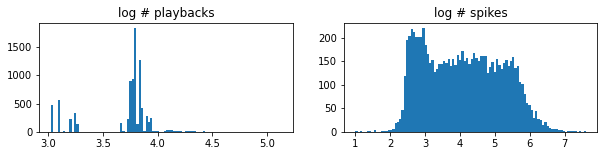

B1597 total # merged units: 8711


unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   56.0s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:  1.5min
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:  2.2min
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  2.7min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  3.0min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  3.3min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  3.6min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  4.1min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  4.4min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  5.1min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  5.2min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  5.6min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

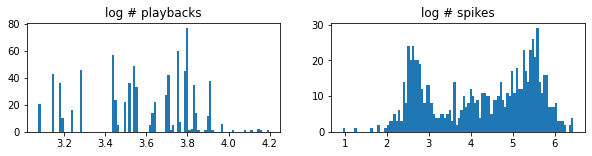

B1188 total # merged units: 821


unit:   0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   25.2s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:   30.5s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:   48.9s
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:   53.5s
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:   54.0s
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:   55.4s
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:   56.5s
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  1.6min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

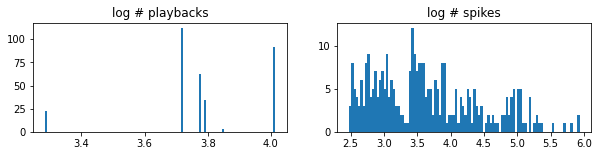

B1595 total # merged units: 325


unit:   0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Batch computation too fast (0.0774s.) Setting batch_size=2.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:    0.8s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=28)]: Done  59 tasks      | elapsed:    1.6s
[Parallel(n_jobs=28)]: Done  88 tasks      | elapsed:    2.3s
[Parallel(n_jobs=28)]: Done 122 tasks      | elapsed:    2.9s
[Parallel(n_jobs=28)]: Done 156 tasks      | elapsed:    3.3s
[Parallel(n_jobs=28)]: Batch computation too slow (3.4688s.) Setting batch_size=1.
[Parallel(n_jobs=28)]: Done 194 tasks      | elapsed:   12.7s
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:   21.0s
[Parallel(n_jobs=28)]: Done 270 out of 325 | elapsed:   29.0s remaining:    5.9s
[Parallel(n_jobs=28)]: Done 303 out of 325 | elapsed:   

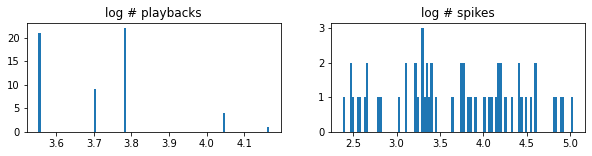

B1276 total # merged units: 57


unit:   0%|          | 0/57 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Batch computation too fast (0.1812s.) Setting batch_size=2.
[Parallel(n_jobs=28)]: Done   8 out of  57 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=28)]: Done  14 out of  57 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=28)]: Done  20 out of  57 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=28)]: Done  26 out of  57 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=28)]: Done  32 out of  57 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=28)]: Done  38 out of  57 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=28)]: Done  44 out of  57 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=28)]: Done  50 out of  57 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=28)]: Done  57 out of  57 | elapsed:    1.2s finished


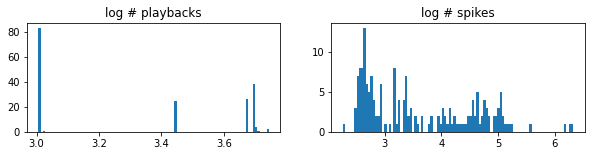

B1426 total # merged units: 180


unit:   0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Batch computation too fast (0.0785s.) Setting batch_size=2.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:    0.9s
[Parallel(n_jobs=28)]: Done  43 tasks      | elapsed:    1.2s
[Parallel(n_jobs=28)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=28)]: Done 106 out of 180 | elapsed:    2.6s remaining:    1.8s
[Parallel(n_jobs=28)]: Done 125 out of 180 | elapsed:    2.8s remaining:    1.2s
[Parallel(n_jobs=28)]: Done 144 out of 180 | elapsed:    2.9s remaining:    0.7s
[Parallel(n_jobs=28)]: Done 163 out of 180 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=28)]: Done 180 out of 180 | elapsed:   14.8s finished


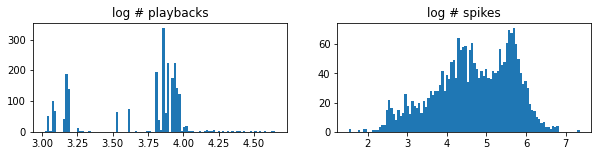

B1432 total # merged units: 2364


unit:   0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   15.7s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   25.7s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   32.7s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:   57.1s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  1.7min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  1.9min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  2.2min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  2.5min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  2.7min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  3.0min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  3.3min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

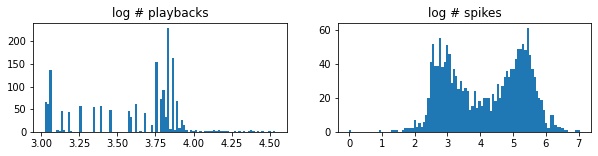

B1170 total # merged units: 1693


unit:   0%|          | 0/1693 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   10.8s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   29.1s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   37.3s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   39.2s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:   47.5s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:   57.9s
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.1min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  1.8min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  1.9min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  2.1min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

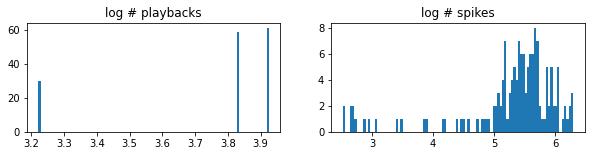

B1244 total # merged units: 150


unit:   0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   25.6s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   28.4s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   44.7s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   53.8s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:   56.7s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done 111 out of 150 | elapsed:  1.4min remaining:   28.6s
[Parallel(n_jobs=28)]: Done 127 out of 150 | elapsed:  1.6min remaining:   17.0s
[Parallel(n_jobs=28)]: Done 143 out of 150 | elapsed:  1.6min remaining:    4.8s
[Parallel(n_jobs=28)]: Done 150 out of 150 | elapsed:  1.7min finished


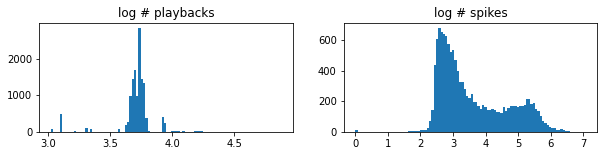

B1593 total # merged units: 13260


unit:   0%|          | 0/13260 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   25.1s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   34.5s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   39.2s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   58.6s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  1.5min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  1.9min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  2.2min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  2.4min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  2.7min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  3.0min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  3.1min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

[Parallel(n_jobs=28)]: Done 9550 tasks      | elapsed: 62.2min
[Parallel(n_jobs=28)]: Done 9689 tasks      | elapsed: 62.9min
[Parallel(n_jobs=28)]: Done 9828 tasks      | elapsed: 63.3min
[Parallel(n_jobs=28)]: Done 9969 tasks      | elapsed: 64.1min
[Parallel(n_jobs=28)]: Done 10110 tasks      | elapsed: 64.8min
[Parallel(n_jobs=28)]: Done 10253 tasks      | elapsed: 65.4min
[Parallel(n_jobs=28)]: Done 10396 tasks      | elapsed: 66.2min
[Parallel(n_jobs=28)]: Done 10541 tasks      | elapsed: 66.7min
[Parallel(n_jobs=28)]: Done 10686 tasks      | elapsed: 67.3min
[Parallel(n_jobs=28)]: Done 10833 tasks      | elapsed: 68.0min
[Parallel(n_jobs=28)]: Done 10980 tasks      | elapsed: 69.0min
[Parallel(n_jobs=28)]: Done 11129 tasks      | elapsed: 69.4min
[Parallel(n_jobs=28)]: Done 11278 tasks      | elapsed: 69.9min
[Parallel(n_jobs=28)]: Done 11429 tasks      | elapsed: 70.4min
[Parallel(n_jobs=28)]: Done 11580 tasks      | elapsed: 70.5min
[Parallel(n_jobs=28)]: Done 11733 tasks     

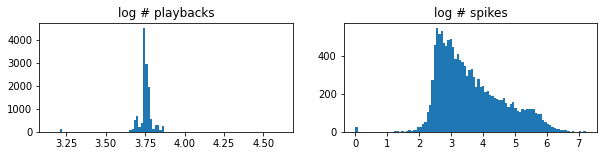

B1248 total # merged units: 13184


unit:   0%|          | 0/13184 [00:00<?, ?it/s]

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   11.7s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   29.0s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   32.6s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   41.0s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:   57.1s
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  1.1min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  1.7min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  1.9min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  2.2min
[Parallel(n_jobs=28)]: Done 186 tasks      | elapsed:  2.4min
[Parallel(n_jobs=28)]: Done 209 tasks      | elapsed:  2.6min
[Parallel(n_jobs=28)]: Done 232 tasks      | elapsed:  3.0min
[Parallel(n_jobs=28)]: Done 257 tasks      | elapsed:  

[Parallel(n_jobs=28)]: Done 9885 tasks      | elapsed: 46.7min
[Parallel(n_jobs=28)]: Done 10026 tasks      | elapsed: 47.6min
[Parallel(n_jobs=28)]: Done 10169 tasks      | elapsed: 48.7min
[Parallel(n_jobs=28)]: Done 10312 tasks      | elapsed: 49.2min
[Parallel(n_jobs=28)]: Done 10457 tasks      | elapsed: 49.4min
[Parallel(n_jobs=28)]: Done 10602 tasks      | elapsed: 49.7min
[Parallel(n_jobs=28)]: Done 10749 tasks      | elapsed: 50.2min
[Parallel(n_jobs=28)]: Done 10896 tasks      | elapsed: 51.7min
[Parallel(n_jobs=28)]: Done 11045 tasks      | elapsed: 52.7min
[Parallel(n_jobs=28)]: Done 11194 tasks      | elapsed: 54.0min
[Parallel(n_jobs=28)]: Done 11345 tasks      | elapsed: 54.2min
[Parallel(n_jobs=28)]: Done 11496 tasks      | elapsed: 54.5min
[Parallel(n_jobs=28)]: Done 11649 tasks      | elapsed: 55.7min
[Parallel(n_jobs=28)]: Done 11802 tasks      | elapsed: 57.1min
[Parallel(n_jobs=28)]: Done 11957 tasks      | elapsed: 57.3min
[Parallel(n_jobs=28)]: Done 12112 tasks  

In [13]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    recording_summary_df = pd.read_pickle(spikesorting_folder/ 'recording_df.pickle')

    # get units that are to be merged
    merged_units = pd.read_pickle(spikesorting_folder / 'unit_clusters2.pickle')
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))

    ensure_dir(spikesorting_folder / 'unit_statistics' / statistics_timestamp)
    
    #if bird == 'B1593':
    #    break
    #else:
    #    continue
    #breakme
    Parallel(n_jobs = 28, verbose=10)(
        delayed(get_unit_statistic)(
            unit_to_analyze,
            spikesorting_folder,
            statistics_timestamp,
            recompute=True,
            parallel=True,
            n_interp_point_bins=16,
            exclude_non_responses=True,
            passive=False
                    )
        for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        )
    );

In [14]:
bird

'B1248'

### Debugging

In [15]:
breakme

NameError: name 'breakme' is not defined

In [ ]:
np.where(merged_units.cluster_id == 100)

In [ ]:
Parallel(n_jobs=1, verbose=10)(
    delayed(get_unit_statistic)(
        unit_to_analyze,
        spikesorting_folder,
        statistics_timestamp,
        recompute=True,
        parallel=False,
        save=False,
        plot=False,
    )
    for uniti, unit_to_analyze in tqdm(
        merged_units[56:]
        .iterrows(), desc="unit", total=len(merged_units)
    )
)

In [ ]:
%debug

In [ ]:
%debug

### make dataframe

In [ ]:
ensure_dir(DATA_DIR / 'unit_statistics' / statistics_timestamp / identifier)

In [ ]:
def read_and_unit(i):
    try:
        df = pd.read_pickle(i)
        df['unit'] = i.stem
        return df
    except:
        return

In [ ]:
for bird, timestamp, sorter in tqdm(birds):
    print(bird)
    spikesorting_folder = DATA_DIR / "spikesorting" / bird / timestamp
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")

    unit_series_save_loc = (
        spikesorting_folder / "unit_statistics" / statistics_timestamp / identifier
    )
    unit_pickles = list(unit_series_save_loc.glob("*.pickle"))
    if len(unit_pickles) == 0:
        print('\t no units')
        continue
    unit_statistics_df = pd.concat(Parallel(n_jobs=-1, prefer="threads")(
            delayed(read_and_unit)(i)
            for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
        ))
    #break
    print(bird, len(unit_statistics_df.unit.unique()))
    unit_statistics_df.to_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )

In [ ]:
len(unit_statistics_df.unit.unique())

In [ ]:
test = Parallel(n_jobs=-1, prefer="threads")(
            delayed(read_and_unit)(i)
            for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
        )

In [ ]:
[len(i) for i in test]

In [ ]:
len(unit_statistics_df)

In [ ]:
unit_statistics_df[:3]